In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,roc_auc_score,roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb

In [3]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
traindata=pd.read_csv("/kaggle/input/amexpert2019/train.csv")
testdata=pd.read_csv("/kaggle/input/amexpert2019/test.csv")
campaigndata=pd.read_csv("/kaggle/input/amexpert2019/campaign_data.csv")
coupon_item_mappingdata=pd.read_csv("/kaggle/input/amexpert2019/coupon_item_mapping.csv")
cust_demodata=pd.read_csv("/kaggle/input/amexpert2019/customer_demographics.csv")
itemdata=pd.read_csv("/kaggle/input/amexpert2019/item_data.csv")
cust_trandata=pd.read_csv("/kaggle/input/amexpert2019/customer_transaction_data.csv")

In [5]:
print('Train Data Shape ---',traindata.shape)
print('Test Data Shape ----', testdata.shape)
print('Campaign Data Shape ----', campaigndata.shape)
print('Coupon Item Mapping Shape ----', coupon_item_mappingdata.shape)
print('Customer Demographic Shape ----', cust_demodata.shape)
print('Item Data Shape ----', itemdata.shape)
print('Customer Transaction Data Shape ----', cust_trandata.shape)


Train Data Shape --- (78369, 5)
Test Data Shape ---- (50226, 4)
Campaign Data Shape ---- (28, 4)
Coupon Item Mapping Shape ---- (92663, 2)
Customer Demographic Shape ---- (760, 7)
Item Data Shape ---- (74066, 4)
Customer Transaction Data Shape ---- (1324566, 7)


In [6]:
print(' Train Columns :' ,traindata.columns)
print('Campaign Data columns :', campaigndata.columns)
print('Coupon Item Mapping columns ----', coupon_item_mappingdata.columns)
print('Customer Demographic columns ----', cust_demodata.columns)
print('Item Data columns ----', itemdata.columns)
print('Customer Transaction Data columns ----', cust_trandata.columns)

 Train Columns : Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status'], dtype='object')
Campaign Data columns : Index(['campaign_id', 'campaign_type', 'start_date', 'end_date'], dtype='object')
Coupon Item Mapping columns ---- Index(['coupon_id', 'item_id'], dtype='object')
Customer Demographic columns ---- Index(['customer_id', 'age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children', 'income_bracket'],
      dtype='object')
Item Data columns ---- Index(['item_id', 'brand', 'brand_type', 'category'], dtype='object')
Customer Transaction Data columns ---- Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount'],
      dtype='object')


In [7]:
campaigndata.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [8]:
def BuildDataSet(initialDataSet):
  campaign=pd.merge(initialDataSet, campaigndata, how='left', on=['campaign_id'])
  campaign.drop_duplicates(inplace=True)

  _campaign_cust=pd.merge(campaign, cust_demodata, how='left', on=['customer_id'])
  _campaign_cust.drop_duplicates(inplace=True)

  customer_data = (cust_trandata.groupby('customer_id').agg({  # 'date':['min'],
                                                              'quantity':['mean'],
                                                              'selling_price':['mean'],
                                                              'other_discount':['mean'],
                                                              'coupon_discount':['mean']
                                                              })).reset_index()
  customer_data.columns = ['customer_id','quantity','selling_price','other_discount','coupon_discount']
  # print(customer_data.head())
  customer_data.drop_duplicates(inplace=True)

  _campaign_cust_tran=pd.merge(_campaign_cust, customer_data, how='left', on=['customer_id'])
  _campaign_cust_tran.drop_duplicates(inplace=True)
  # print(_campaign_cust_tran.columns)

  coupon_item_data=pd.merge(coupon_item_mappingdata, itemdata, how='left', on=['item_id'])

  coupon_item_data=coupon_item_data.groupby('coupon_id').agg({
#         'item_id':['mean'],
        'brand':['mean'],
        'brand_type':['max'],
        'category':['max']
  }).reset_index()
  coupon_item_data.columns = ['coupon_id','brand','brand_type','category'] 
#     'item_id'
  # coupon_item_data.head()
  coupon_item_data.drop_duplicates(inplace=True)

  _campaign_cust_tran_coupon=pd.merge(_campaign_cust_tran, coupon_item_data, how='left', on=['coupon_id'])
  _campaign_cust_tran_coupon.drop_duplicates(inplace=True)

  # coupon_data = (coupon_item_data.groupby('coupon_id').agg({'item_id': ['max']})).reset_index()
  # coupon_data.columns = ['coupon_id','item_id']
  # coupon_data.drop_duplicates(inplace=True)
  # # print(coupon_data.columns)

  # _campaign_cust_coupon_tran=pd.merge(_campaign_cust_tran, coupon_data, how='left', on=['coupon_id'])
  # _campaign_cust_coupon_tran.drop_duplicates(inplace=True)
  # # print(_campaign_cust_coupon_tran.columns)

  # _campaign_cust_coupon_tran['item_id']=_campaign_cust_coupon_tran['item_id_x']

  # _campaign_cust_coupon_trans_item=pd.merge(_campaign_cust_coupon_tran, itemdata, how='left', on=['item_id','item_id'])
  # _campaign_cust_coupon_trans_item.drop_duplicates(inplace=True)
  # print(_campaign_cust_coupon_trans_item.head())

  return _campaign_cust_tran_coupon

In [9]:
finaltrain=BuildDataSet(traindata)
print(finaltrain.shape)
finaltest=BuildDataSet(testdata)
print(finaltest.shape)

(78369, 21)
(50226, 20)


In [11]:
finaltrain.isnull().sum()

id                       0
campaign_id              0
coupon_id                0
customer_id              0
redemption_status        0
campaign_type            0
start_date               0
end_date                 0
age_range            34708
marital_status       52975
rented               34708
family_size          34708
no_of_children       64313
income_bracket       34708
quantity                 0
selling_price            0
other_discount           0
coupon_discount          0
brand                    0
brand_type               0
category                 0
dtype: int64

In [12]:
dict={}
def GetUniqueValues(df):
  dict={}
  for i in df.columns:
    dict[i]=df[i].unique()
  return dict

GetUniqueValues(finaltrain)

{'id': array([     1,      2,      6, ..., 128590, 128592, 128595]),
 'campaign_id': array([13,  9,  8, 11, 29, 30,  2,  5, 12, 26,  3,  4, 10,  7, 28, 27,  6,
         1]),
 'coupon_id': array([  27,  116,  635,  644, 1017,  795,  444,  538,  857,  559,  575,
        1028,  705,  517,  893,  796,  506,  689,  268,    8,  674,  320,
         109,  278, 1031,  326,  363,  911,  383,  482,  813,  118,  663,
         332,  500,  757, 1067,   87,  905, 1114,  152,   57,  271,  413,
         582,  333,  485,  256,  980,  700,  628,  136,  750,  854,  761,
         828,  881,  129,  867,  709,  169, 1083,  530,  822,  126,  917,
          22,  960,   24,  772,  603,  982,  510,  132,   60, 1063,  166,
         679,  839,  459,  658,  106,  168,  473,  627,  145,    7,  667,
         924,  621,  467,  985,  171, 1056,  890,  920,  279,  948,  368,
         107,   19,  800,  420,  756,  783,  687,  913,  725,  483,  275,
         788,  170,   14,  416,   54,  113,  125,  902,  526,  144,  554,

In [13]:
# #Treat Missing values
finaltrain['age_range'] = finaltrain['age_range'].fillna(finaltrain['age_range'].mode()[0])
finaltrain['marital_status'] = finaltrain['marital_status'].fillna(finaltrain['marital_status'].mode()[0])
finaltrain['rented'] = finaltrain['rented'].fillna(finaltrain['rented'].mode()[0])
finaltrain['family_size'] = finaltrain['family_size'].fillna(finaltrain['family_size'].mode()[0])
finaltrain['no_of_children'] = finaltrain['no_of_children'].fillna(finaltrain['no_of_children'].mode()[0])
finaltrain['income_bracket'] = finaltrain['income_bracket'].fillna(finaltrain['income_bracket'].mean())

finaltest['age_range'] = finaltest['age_range'].fillna(finaltest['age_range'].mode()[0])
finaltest['marital_status'] = finaltest['marital_status'].fillna(finaltest['marital_status'].mode()[0])
finaltest['rented'] = finaltest['rented'].fillna(finaltest['rented'].mode()[0])
finaltest['family_size'] = finaltest['family_size'].fillna(finaltest['family_size'].mode()[0])
finaltest['no_of_children'] = finaltest['no_of_children'].fillna(finaltest['no_of_children'].mode()[0])
finaltest['income_bracket'] = finaltest['income_bracket'].fillna(finaltest['income_bracket'].mean())

In [14]:
# From boxplot we can observe their is an outlier for quantity  above 460 its an outlier so do capping

finaltrain['quantity'][finaltrain['quantity']>=460]=460
finaltest['quantity'][finaltest['quantity']>=460]=460


# From boxplot we can observe their is an outlier for selling_price  above 176 its an outlier so do capping & flooring

finaltrain['selling_price'][finaltrain['selling_price']>=176]=176
finaltest['selling_price'][finaltest['selling_price']>=176]=176

finaltest['selling_price'][finaltest['selling_price']<=65]=65

# From boxplot we can observe their is an outlier for other_discount below -30 its an outlier

finaltrain['other_discount'][finaltrain['other_discount']<=-29]=-30
finaltest['other_discount'][finaltest['other_discount']<=-29]=-30

# from boxplot we can observe their is an outlier for coupon_discount below

finaltrain['coupon_discount'][finaltrain['coupon_discount']<=-1.5]=-1.5
finaltest['coupon_discount'][finaltest['coupon_discount']<=-1.5]=-1.5

# from boxplot we can observe their is an outlier for brand below
finaltrain['brand'][finaltrain['brand']>=2416]=2416
finaltest['brand'][finaltest['brand']>=2416]=2416



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [15]:
import sys
np.set_printoptions(threshold=sys.maxsize)
np.percentile(finaltest['selling_price'], [  80,85,86,87,88,89,90,95,100])
                                       
# 0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]

array([135.28385485, 141.42611814, 142.7161307 , 144.32492074,
       145.64370074, 147.3128103 , 148.74898258, 165.10231831,
       176.        ])

In [ ]:
# sns.boxplot(finaltrain['item_id'])
# plt.show()

In [16]:
#Creating new feature
finaltrain['start_date'] = pd.to_datetime(finaltrain['start_date'])
finaltrain['end_date'] = pd.to_datetime(finaltrain['end_date'])

finaltest['start_date'] = pd.to_datetime(finaltest['start_date'])
finaltest['end_date'] = pd.to_datetime(finaltest['end_date'])


finaltrain['end_date_month'] = finaltrain['end_date'].dt.month
finaltrain['end_date_dayofweek'] = finaltrain['end_date'].dt.dayofweek 
finaltrain['end_date_dayofyear'] = finaltrain['end_date'].dt.dayofyear 
finaltrain['end_date_days_in_month'] = finaltrain['end_date'].dt.days_in_month 
finaltrain['start_date_month'] = finaltrain['start_date'].dt.month
finaltrain['start_date_dayofweek'] = finaltrain['start_date'].dt.dayofweek 
finaltrain['start_date_dayofyear'] = finaltrain['start_date'].dt.dayofyear 
finaltrain['start_date_days_in_month'] = finaltrain['start_date'].dt.days_in_month
finaltrain['diff_dayofweek'] = finaltrain['end_date_dayofweek'] - finaltrain['start_date_dayofweek']
finaltrain['diff_dayofyear'] = finaltrain['end_date_dayofyear'] - finaltrain['start_date_dayofyear']

finaltest['end_date_month'] = finaltest['end_date'].dt.month
finaltest['end_date_dayofweek'] = finaltest['end_date'].dt.dayofweek 
finaltest['end_date_dayofyear'] = finaltest['end_date'].dt.dayofyear 
finaltest['end_date_days_in_month'] = finaltest['end_date'].dt.days_in_month 
finaltest['start_date_month'] = finaltest['start_date'].dt.month
finaltest['start_date_dayofweek'] = finaltest['start_date'].dt.dayofweek 
finaltest['start_date_dayofyear'] = finaltest['start_date'].dt.dayofyear 
finaltest['start_date_days_in_month'] = finaltest['start_date'].dt.days_in_month
finaltest['diff_dayofweek'] = finaltest['end_date_dayofweek'] - finaltest['start_date_dayofweek']
finaltest['diff_dayofyear'] = finaltest['end_date_dayofyear'] - finaltest['start_date_dayofyear']


finaltrain['campaign_days']=((pd.to_datetime(finaltrain['end_date'], format='%d/%m/%y')) - 
                             (pd.to_datetime(finaltrain['start_date'], format='%d/%m/%y'))).dt.days

finaltest['campaign_days']=((pd.to_datetime(finaltest['end_date'], format='%d/%m/%y')) - 
                             (pd.to_datetime(finaltest['start_date'], format='%d/%m/%y'))).dt.days

In [17]:
finaltrain.describe(include='all')

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,age_range,marital_status,...,end_date_dayofweek,end_date_dayofyear,end_date_days_in_month,start_date_month,start_date_dayofweek,start_date_dayofyear,start_date_days_in_month,diff_dayofweek,diff_dayofyear,campaign_days
count,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369,78369,78369,78369,78369,...,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000
unique,NaN,NaN,NaN,NaN,NaN,2,17,17,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,X,2013-05-19 00:00:00,2013-05-07 00:00:00,46-55,Married,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,57684,22606,22606,49862,71786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-10 00:00:00,2012-09-21 00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01 00:00:00,2013-12-04 00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,64347.975449,13.974441,566.363243,787.451888,0.009302,NaN,NaN,NaN,NaN,NaN,...,3.097717,159.780717,30.698873,5.840753,4.457132,161.988465,29.878893,-1.359415,-2.207748,34.154538
std,37126.440855,8.019215,329.966054,456.811339,0.095999,NaN,NaN,NaN,NaN,NaN,...,1.907805,77.694575,0.617712,3.627045,2.119305,108.053809,1.308569,2.829341,110.149767,78.669091
min,1.000000,1.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,3.000000,28.000000,1.000000,0.000000,28.000000,28.000000,-5.000000,-334.000000,-289.000000
25%,32260.000000,8.000000,280.000000,399.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,1.000000,124.000000,31.000000,2.000000,5.000000,47.000000,28.000000,-5.000000,-12.000000,-12.000000


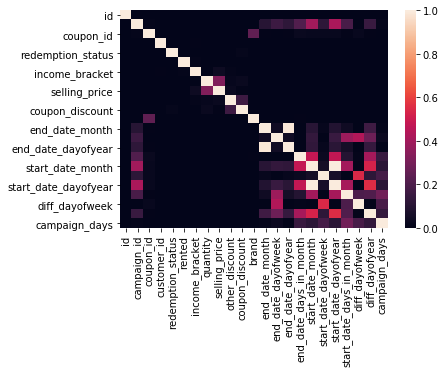

In [18]:
corr=finaltrain.corr()**2
sns.heatmap(corr)
plt.show()

In [ ]:
# sns.pairplot(finaltrain, hue='redemption_status')
# plt.show()

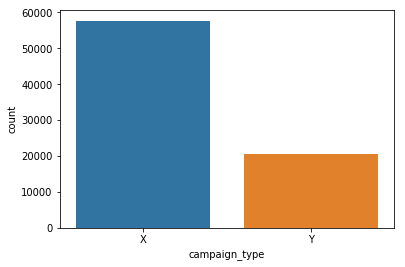

In [19]:
sns.countplot('campaign_type', data=finaltrain)
plt.show()

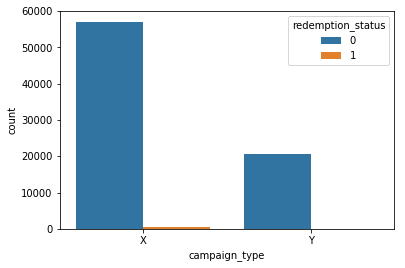

In [20]:
# check based on campaign Type , will cusotmers redemed ?. Yes X campaign customers redemeed
sns.countplot('campaign_type', hue='redemption_status', data=finaltrain)

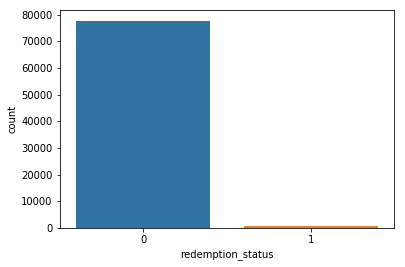

In [21]:
# it saying imbalanced data set
sns.countplot('redemption_status', data=finaltrain)

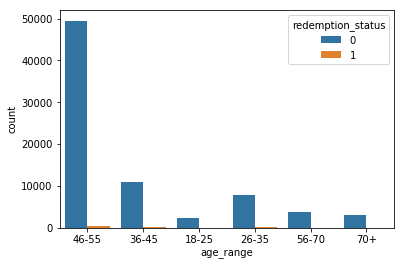

In [22]:
# check with age group redeemed 
sns.countplot('age_range',hue='redemption_status', data=finaltrain)

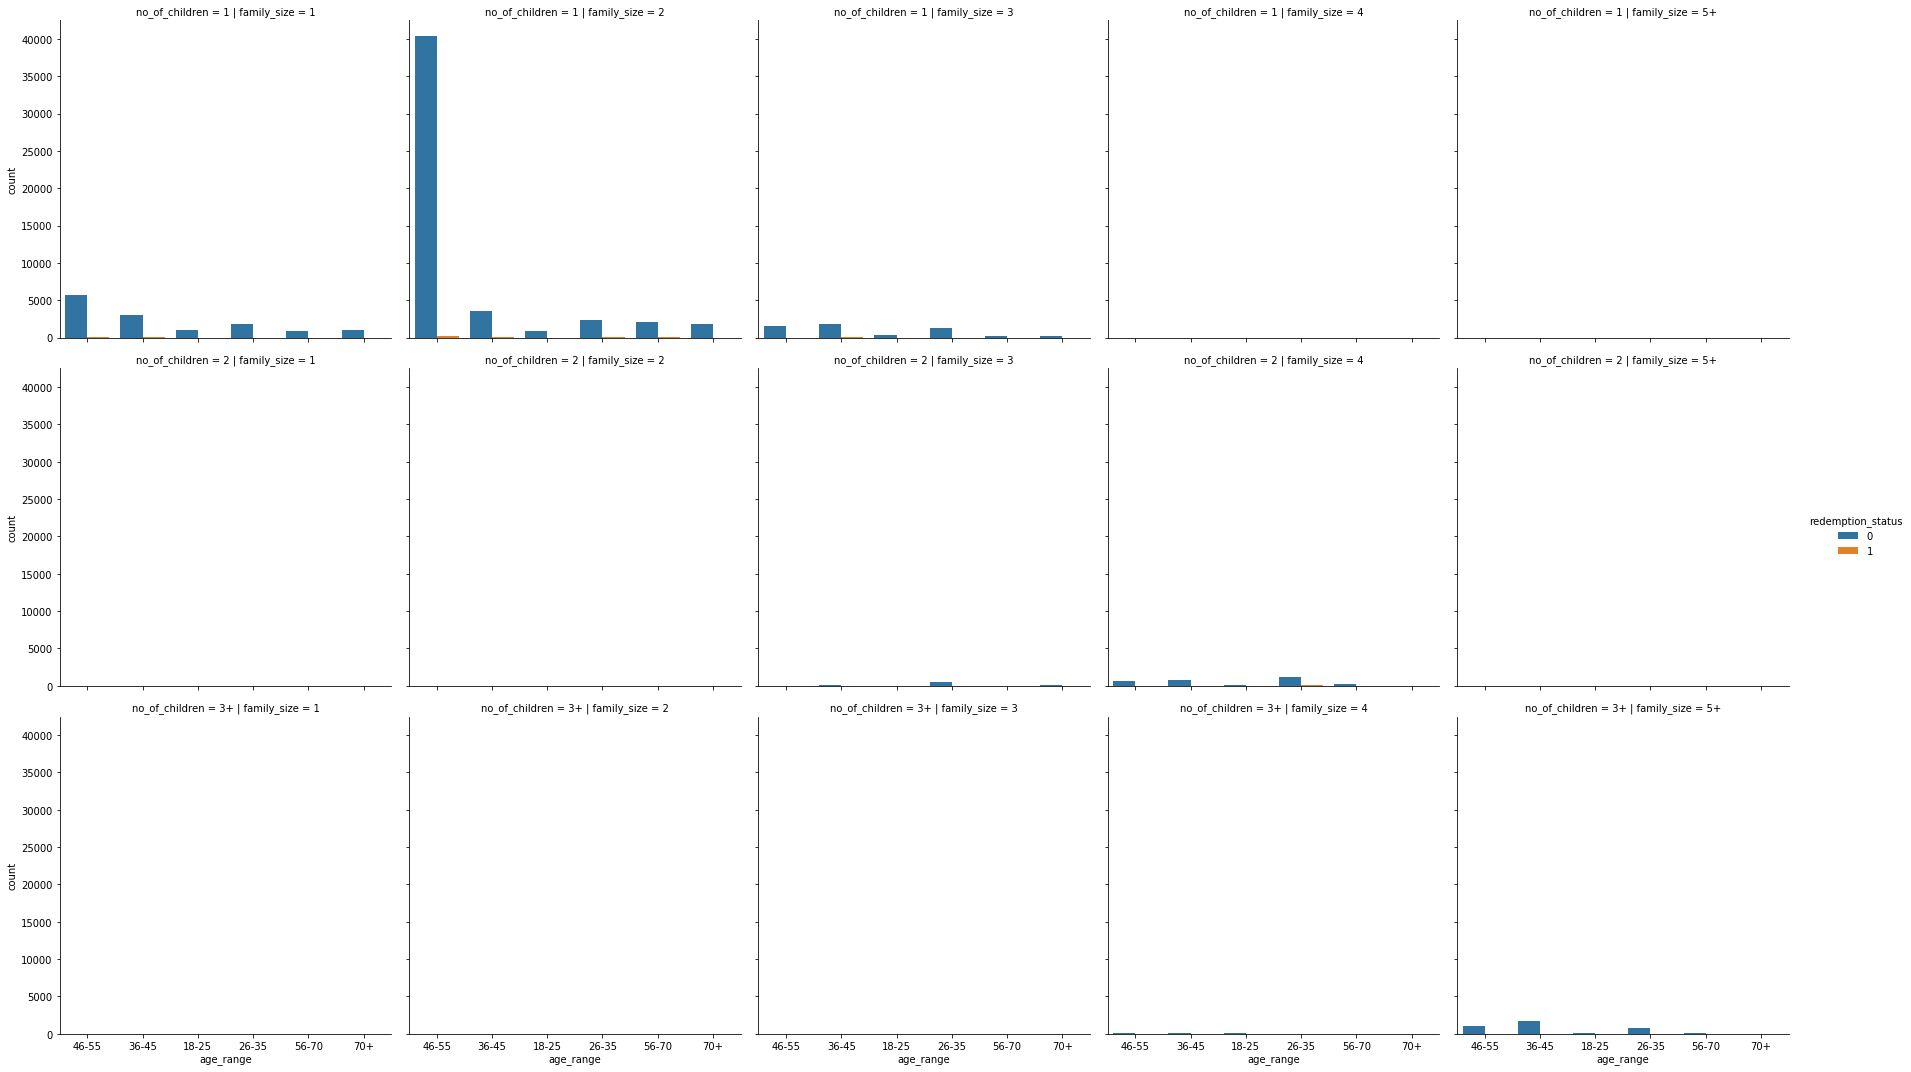

In [23]:
# check with age group redeemed 
sns.catplot(x='age_range',hue='redemption_status', col='family_size',row='no_of_children',data=finaltrain, kind='count')

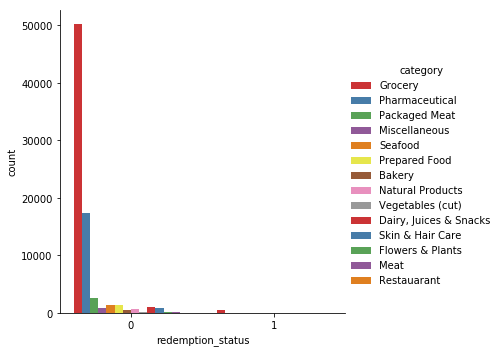

In [24]:
#mostly redemption used in Grocery only
sns.catplot(x='redemption_status', hue='category', data=finaltrain, kind='count', palette='Set1')

In [25]:
def HandleCategoryFeatures(traindf, testdf):    

    # Handling Category features

    traindf['age_range']=traindf['age_range'].replace('46-55',46)
    traindf['age_range']=traindf['age_range'].replace('36-45',36)
    traindf['age_range']=traindf['age_range'].replace('18-25',18)
    traindf['age_range']=traindf['age_range'].replace('26-35',26)
    traindf['age_range']=traindf['age_range'].replace('56-70',56)
    traindf['age_range']=traindf['age_range'].replace('70+',70)

    traindf['family_size']=traindf['family_size'].replace('5+',5)

    traindf['no_of_children']=traindf['no_of_children'].replace('3+',3)

    traindf['no_of_children']=traindf['no_of_children'].astype(int)
    traindf['family_size']=traindf['family_size'].astype(int)
    traindf['age_range']=traindf['age_range'].astype(int)
    traindf['rented']=traindf['rented'].astype(int)    

    testdf['age_range']=testdf['age_range'].replace('46-55',46)
    testdf['age_range']=testdf['age_range'].replace('36-45',36)
    testdf['age_range']=testdf['age_range'].replace('18-25',18)
    testdf['age_range']=testdf['age_range'].replace('26-35',26)
    testdf['age_range']=testdf['age_range'].replace('56-70',56)
    testdf['age_range']=testdf['age_range'].replace('70+',70)

    testdf['family_size']=testdf['family_size'].replace('5+',5)
    testdf['no_of_children']=testdf['no_of_children'].replace('3+',3)


    testdf['no_of_children']=testdf['no_of_children'].astype(int)
    testdf['family_size']=testdf['family_size'].astype(int)
    testdf['age_range']=testdf['age_range'].astype(int)
    testdf['rented']=testdf['rented'].astype(int)         

In [45]:
feature={}
final_pred_test_full =0
def MOdelExecution(model):
    
    kf = StratifiedKFold(n_splits=2,shuffle=True,random_state=45)
    pred_test_full=0
    cv_score =[]
    TrainScore=[]
    Testscore=[]
    F1Score=[]
    Sensitivity=[]
    Specificity=[]
    Auc=[]
    i=1
    feature_importances=[]
    for train_index,test_index in kf.split(X,Y):
        print('{} of KFold {}'.format(i,kf.n_splits))
        xtr,xvl = X.loc[train_index],X.loc[test_index]
        ytr,yvl = Y.loc[train_index],Y.loc[test_index]
        
        mod=model
        mod.fit(xtr,ytr)
        pred=mod.predict(xvl)
        
        rocscore = roc_auc_score(yvl,mod.predict(xvl))
        cv_score.append(rocscore)  
        
        Score=mod.score(xtr,ytr)
        
        TrainScore.append(Score)
        
        Testaccuracy=accuracy_score(yvl,mod.predict(xvl))
        
        Testscore.append(Testaccuracy)

        confusion=confusion_matrix(yvl, pred)

        y_pred_quant = mod.predict_proba(xvl)[:, 1]

        f1=f1_score(yvl, pred)        
        F1Score.append(f1)

        total=sum(sum(confusion))

        sensitivity = confusion[0,0]/(confusion[0,0]+confusion[1,0])
        
        Sensitivity.append(sensitivity)

        specificity = confusion[1,1]/(confusion[1,1]+confusion[0,1])
        
        Specificity.append(specificity)

        fpr, tpr, thresholds = roc_curve(yvl, y_pred_quant)
        
        Auc.append(auc(fpr,tpr))
        
        pred_test_full +=y_pred_quant
        i+=1
    final_pred_test_full=pred_test_full
    print('Cv_Score',cv_score)
    print('TrainScore', TrainScore)
    print('TestScore', Testscore)
    print('F1 Score',F1Score)
    print('Sensitivity',Sensitivity)
    print('Specificity',Specificity)    

In [46]:
finaltrain2=finaltrain.copy()
finaltest2=finaltest.copy()

HandleCategoryFeatures(finaltrain2,finaltest2)
finaltrain2=pd.get_dummies(data=finaltrain2, columns=['marital_status', 'campaign_type','brand_type','category'], drop_first=True)

finaltest2=pd.get_dummies(data=finaltest2, columns=['marital_status', 'campaign_type','brand_type','category'], drop_first=True)

#Drop unnecessary columns
finaltrain2.drop(finaltrain2[['id','start_date','end_date']], axis=1, inplace=True)
finaltest2.drop(finaltest2[['start_date','end_date']], axis=1, inplace=True)
# finaltest_oversampling.columns


In [47]:
# 1) Over Sampling
os=RandomOverSampler(ratio=1)
X_train_res, y_train_res=os.fit_sample(finaltrain2.drop(['redemption_status'],axis=1), finaltrain2['redemption_status'])

OverSampleX=pd.DataFrame(X_train_res, columns=finaltrain2.drop('redemption_status', axis=1).columns)
OverSampleY=pd.DataFrame(y_train_res, columns=finaltrain2[['redemption_status']].columns)
finaltrain_oversampling=''
finaltrain_oversampling = pd.concat([OverSampleX, OverSampleY], axis=1)
finaltest_oversampling=''
finaltest_oversampling=finaltest2.copy()


In [110]:
X=finaltrain_oversampling.drop(['redemption_status'], axis=1)
Y=(finaltrain_oversampling[['redemption_status']])

s_scaler = StandardScaler()
df_s = s_scaler.fit_transform(X)
X = pd.DataFrame(df_s, columns=finaltrain_oversampling.drop(['redemption_status'], axis=1).columns)
mod=lgb.LGBMClassifier(boosting_type= 'gbdt', objective= 'binary', metric='auc', bagging_freq=1, subsample=1, feature_fraction= 0.7,
              num_leaves= 8, learning_rate= 0.05, lambda_l1=5,max_bin=255)

MOdelExecution(mod)

1 of KFold 2


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2 of KFold 2


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cv_Score [0.8596470891293149, 0.8633049974240082]
TrainScore [0.8617078825347759, 0.8631504379185987]
TestScore [0.8596470891293148, 0.8633049974240082]
F1 Score [0.8695454382205408, 0.8724322375142737]
Sensitivity [0.9239879741261502, 0.9239741470013527]
Specificity [0.8122609648632327, 0.817825352112676]


In [111]:
# mod.fit(X_Train, Y_Train)
finaltest_new=finaltest_oversampling.copy()

s_scaler = StandardScaler()

df_s = s_scaler.fit_transform(finaltest_new.drop(['id'], axis=1))

X2_Test = pd.DataFrame(df_s, columns=finaltest_new.drop(['id'], axis=1).columns)
X2_Test['id']=finaltest_oversampling['id']
X2_Test['category_Restauarant']=0

Test_Pred=mod.predict(X2_Test.drop(['id'], axis=1))

Test_Prob=mod.predict_proba(X2_Test.drop(['id'], axis=1))[:,1]
finaltest_new['redemption_Prob']=Test_Prob
finaltest_new['redemption_status']=Test_Pred

print(finaltest_new['redemption_status'].value_counts())

print(finaltest_new['redemption_Prob'].value_counts())

finaltest_new['redemption_Prob'] = finaltest_new['redemption_Prob'].apply(lambda x: 1 if x>0.5 else 0)

print(finaltest_new['redemption_Prob'].value_counts())

testdv=finaltest_new[['id','redemption_status']]
testdv.to_csv('final_submission_04_LGBM.csv',index=False)

0    31134
1    19092
Name: redemption_status, dtype: int64
0.815752    82
0.821264    46
0.811889    39
0.270685    38
0.332287    34
            ..
0.356709     1
0.240515     1
0.063376     1
0.838355     1
0.478534     1
Name: redemption_Prob, Length: 28319, dtype: int64
0    31134
1    19092
Name: redemption_Prob, dtype: int64
